Importing Libraries and Dataset

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.linear_model import LinearRegression
import statsmodels
from statsmodels.tsa.arima.model import ARIMA
import tensorflow
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [54]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [55]:
df = pd.read_csv('NFLX.csv', parse_dates=['Date'], index_col='Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
...,...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500
2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300
2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000


Data Preprocessing

In [56]:
df.shape

(1009, 6)

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1009 entries, 2018-02-05 to 2022-02-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1009 non-null   float64
 1   High       1009 non-null   float64
 2   Low        1009 non-null   float64
 3   Close      1009 non-null   float64
 4   Adj Close  1009 non-null   float64
 5   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 55.2 KB


In [58]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1009.000000,1009.000000,1009.000000,1009.000000,1009.000000,1.009000e+03
mean,419.059673,425.320703,412.374044,419.000733,419.000733,7.570685e+06
std,108.537532,109.262960,107.555867,108.289999,108.289999,5.465535e+06
min,233.919998,250.649994,231.229996,233.880005,233.880005,1.144000e+06
25%,331.489990,336.299988,326.000000,331.619995,331.619995,4.091900e+06
50%,377.769989,383.010010,370.880005,378.670013,378.670013,5.934500e+06
75%,509.130005,515.630005,502.529999,509.079987,509.079987,9.322400e+06
max,692.349976,700.989990,686.090027,691.690002,691.690002,5.890430e+07


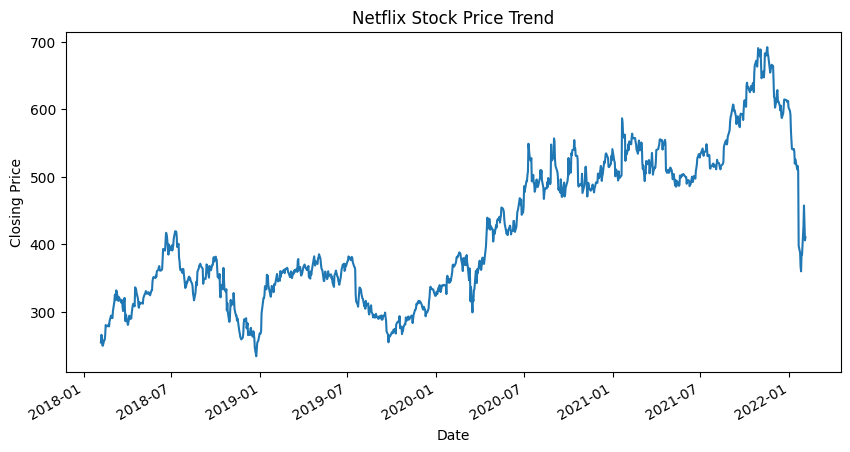

In [59]:
df['Adj Close'].plot(figsize=(10, 5))
plt.title('Netflix Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

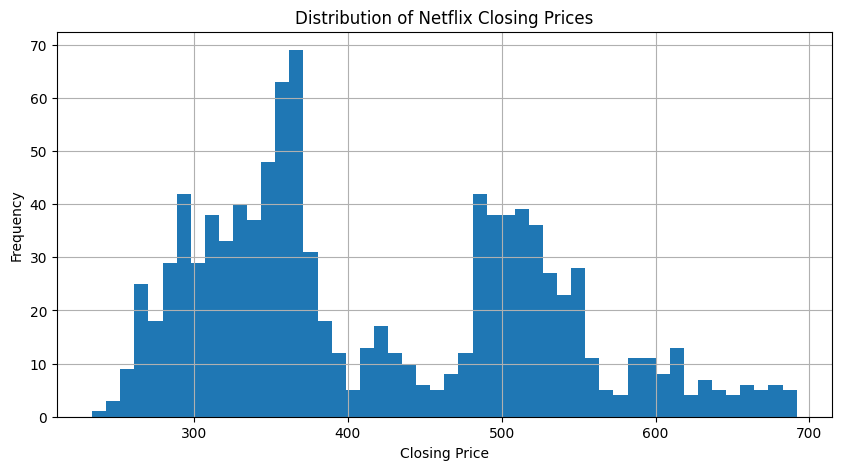

In [60]:
df['Adj Close'].hist(bins=50, figsize=(10, 5))
plt.title('Distribution of Netflix Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

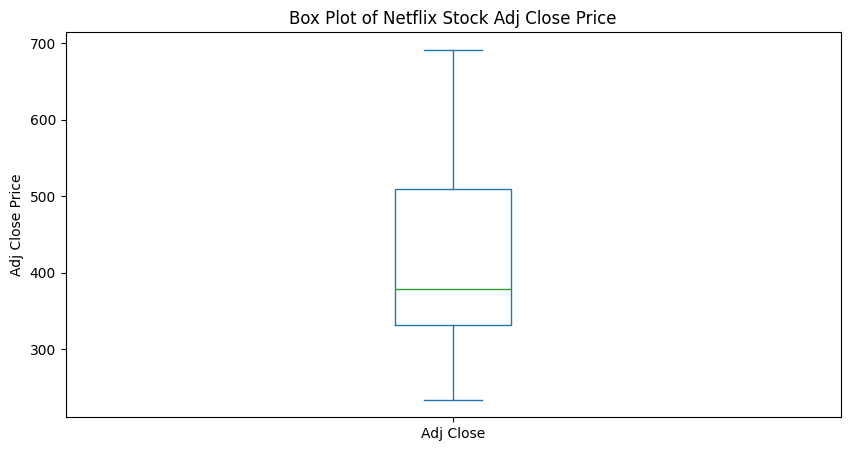

In [61]:
df['Adj Close'].plot(kind='box', figsize=(10, 5))
plt.title('Box Plot of Netflix Stock Adj Close Price')
plt.ylabel('Adj Close Price')
plt.show()

20 Day Moving Average

In [62]:
df['20-Day Moving Avg'] = df['Adj Close'].rolling(window=20).mean()
df['20-Day Moving Avg']
# Drop NaN values from the DataFrame for calculation purposes
df_clean = df.dropna(subset=['Adj Close', '20-Day Moving Avg'])

In [63]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero = y_true != 0
    if np.any(non_zero):
        return np.mean(np.abs((y_true[non_zero] - y_pred[non_zero]) / y_true[non_zero])) * 100
    else:
        return np.inf  # Avoid division by zero

def predictive_accuracy(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    total_actual = np.sum(np.abs(y_true))
    if total_actual != 0:
        return 1 - (np.sum(np.abs(y_true - y_pred)) / total_actual)
    else:
        return np.inf  # Avoid division by zero if total actual is zero

In [64]:
# Calculate MAPE and PA using the cleaned data
mape = mean_absolute_percentage_error(df_clean['Adj Close'], df_clean['20-Day Moving Avg'])
pa = predictive_accuracy(df_clean['Adj Close'], df_clean['20-Day Moving Avg'])

# Convert PA from a decimal to a percentage
pa_percentage = pa * 100

# Print the results
print(f"MAPE: {mape:.2f}%")
print(f"Predictive Accuracy: {pa_percentage:.2f}%")

MAPE: 4.49%
Predictive Accuracy: 95.66%


In [65]:
df

,Open,High,Low,Close,Adj Close,Volume,20-Day Moving Avg
Date,,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,NaN
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,NaN
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,NaN
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,NaN
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,NaN
...,...,...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500,487.853500
2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300,480.841501
2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000,472.758000


SES Model

In [66]:
ses_model = SimpleExpSmoothing(df['Adj Close']).fit(smoothing_level=0.2)
df['SES'] = ses_model.fittedvalues
df['SES']

Date
2018-02-05    254.259995
2018-02-06    254.259995
2018-02-07    256.551996
2018-02-08    258.153597
2018-02-09    256.542878
                 ...    
2022-01-31    418.782756
2022-02-01    420.454208
2022-02-02    427.789368
2022-02-03    428.127496
2022-02-04    423.621998
Name: SES, Length: 1009, dtype: float64

In [67]:
mape = mean_absolute_percentage_error(df['Adj Close'], df['SES'])
pa = predictive_accuracy(df['Adj Close'], df['SES'])
print(f"MAPE: {mape:.2f}%")
print(f"Predictive Accuracy: {pa:.2f}")
pa_percentage = predictive_accuracy(df['Adj Close'], df['SES'])
pa_percent = pa_percentage * 100
print(f"Predictive Accuracy: {pa_percentage:.2f}%")

MAPE: 3.04%
Predictive Accuracy: 0.97
Predictive Accuracy: 0.97%


Level, Trend, Seasonality, Residuals

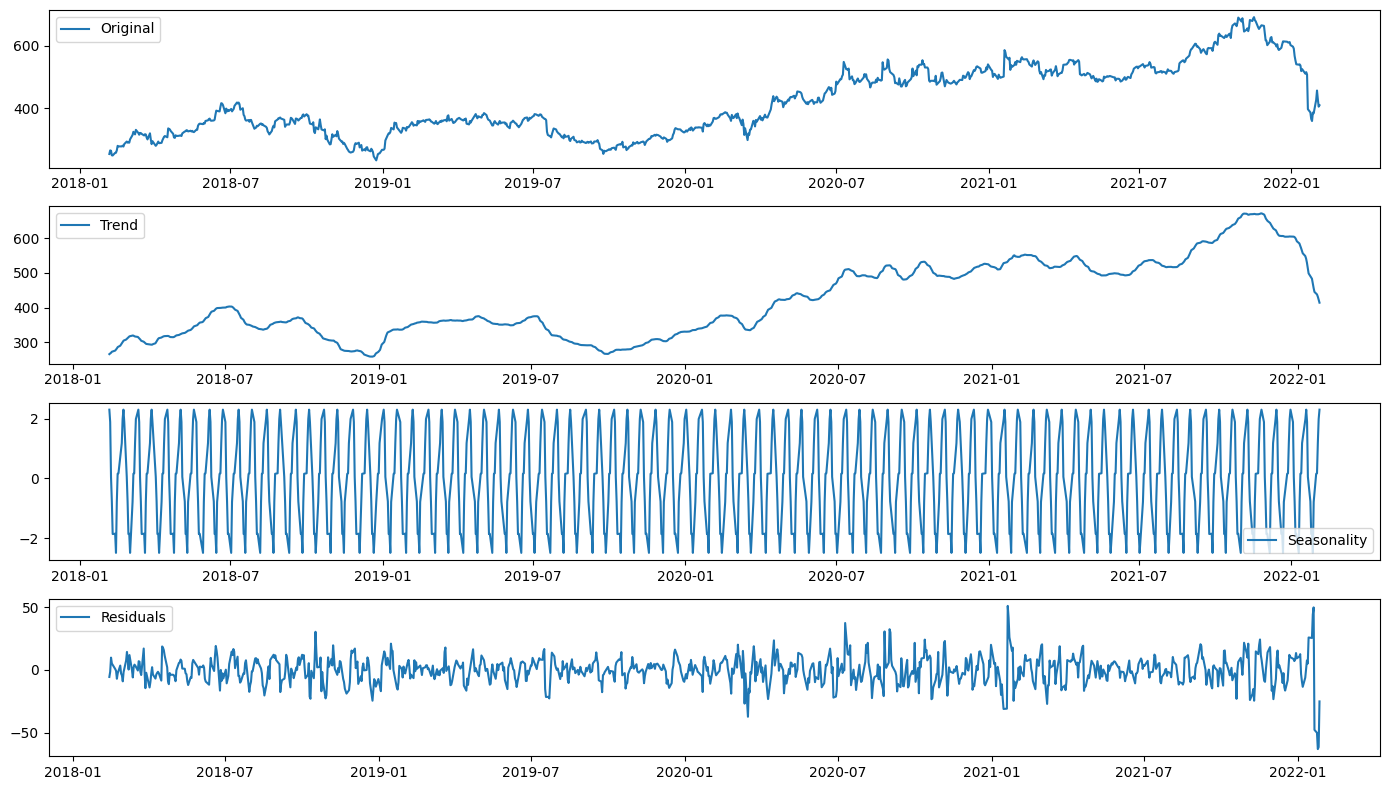

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
df.sort_index(inplace=True)

# Select the column with the time series data
ts = df['Adj Close']

# Perform decomposition
# The model can be either 'additive' or 'multiplicative', depending on your data characteristics
decomposition = seasonal_decompose(ts, model='additive', period=12)  # Adjust the period according to your data's seasonality

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(14, 8))
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

###SES, DES, TES

In [69]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

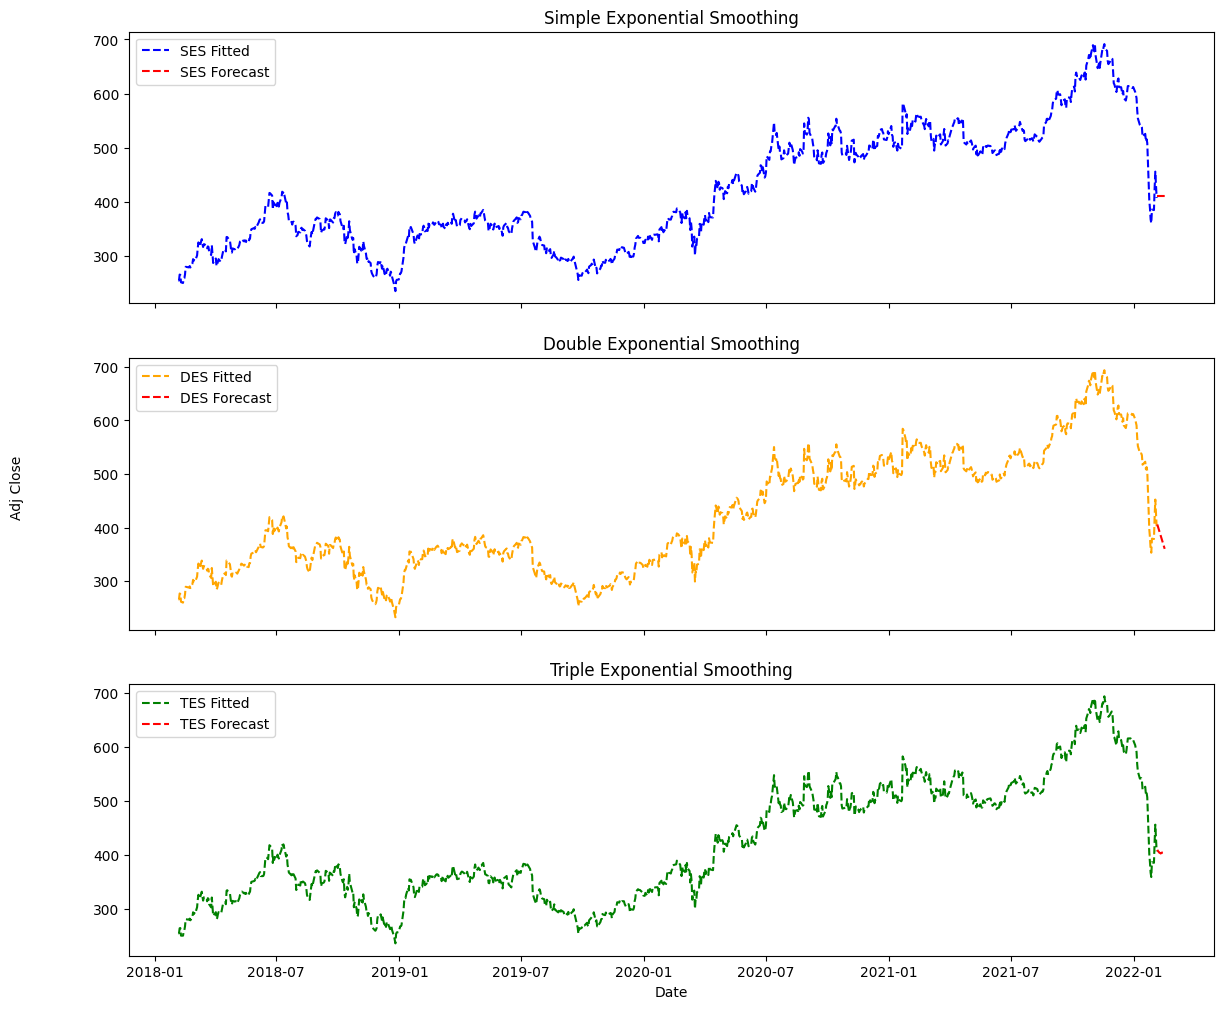

In [70]:
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


df.sort_index(inplace=True)


ses_model = SimpleExpSmoothing(df['Adj Close']).fit()
ses_forecast = ses_model.forecast(12)

des_model = Holt(df['Adj Close']).fit()
des_forecast = des_model.forecast(12)

tes_model = ExponentialSmoothing(df['Adj Close'], trend='add', seasonal='add', seasonal_periods=12).fit()
tes_forecast = tes_model.forecast(12)

# Generate the forecast index
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=12, freq=df.index.freq)

# Plot the results in separate subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# SES plot
axes[0].plot(df.index, ses_model.fittedvalues, label='SES Fitted', linestyle='--', color='blue')
axes[0].plot(forecast_index, ses_forecast, label='SES Forecast', color='red', linestyle='dashed')
axes[0].set_title('Simple Exponential Smoothing')
axes[0].legend()

# DES plot
axes[1].plot(df.index, des_model.fittedvalues, label='DES Fitted', linestyle='--', color='orange')
axes[1].plot(forecast_index, des_forecast, label='DES Forecast', color='red', linestyle='dashed')
axes[1].set_title('Double Exponential Smoothing')
axes[1].legend()

# TES plot
axes[2].plot(df.index, tes_model.fittedvalues, label='TES Fitted', linestyle='--', color='green')
axes[2].plot(forecast_index, tes_forecast, label='TES Forecast', color='red', linestyle='dashed')
axes[2].set_title('Triple Exponential Smoothing')
axes[2].legend()


plt.xlabel('Date')
fig.text(0.04, 0.5, 'Adj Close', va='center', rotation='vertical')

plt.show()

###Checking for Stationarity

In [71]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Adj Close'])
print(result)

(-1.8125906878289957, 0.3742289256820758, 6, 1002, {'1%': -3.436893045520188, '5%': -2.8644287878535146, '10%': -2.568308127138936}, 7545.926742057859)


In [72]:
from statsmodels.tsa.stattools import adfuller
ts = df['Adj Close']
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.812591
p-value: 0.374229
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [73]:
diff_series = ts.diff().dropna()  # First difference of the series


In [74]:
result = adfuller(diff_series)
print(result)

(-14.242275992929107, 1.5304022754298954e-26, 5, 1002, {'1%': -3.436893045520188, '5%': -2.8644287878535146, '10%': -2.568308127138936}, 7538.112957279606)


###Fitting ARIMA Model

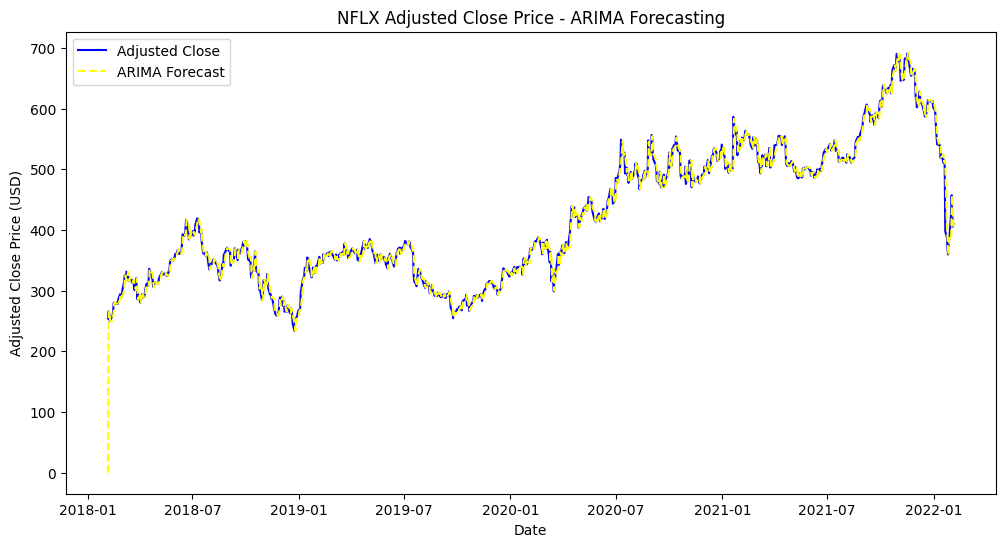

In [75]:
# ARIMA
arima_order = (1, 1, 1)
arima_model = ARIMA(df['Adj Close'], order=arima_order).fit()
df['ARIMA'] = arima_model.predict(start=df.index[0], end=df.index[-1], typ='levels')

# Plotting results
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(df['ARIMA'], label='ARIMA Forecast', color='yellow', linestyle='--')
plt.title('NFLX Adjusted Close Price - ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.show()

In [76]:
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1009
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3850.029
Date:                Fri, 19 Apr 2024   AIC                           7706.058
Time:                        16:38:09   BIC                           7720.805
Sample:                             0   HQIC                          7711.660
                               - 1009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8798      0.119     -7.414      0.000      -1.112      -0.647
ma.L1          0.8509      0.133      6.388      0.000       0.590       1.112
sigma2       121.6347      1.982     61.374      0.0

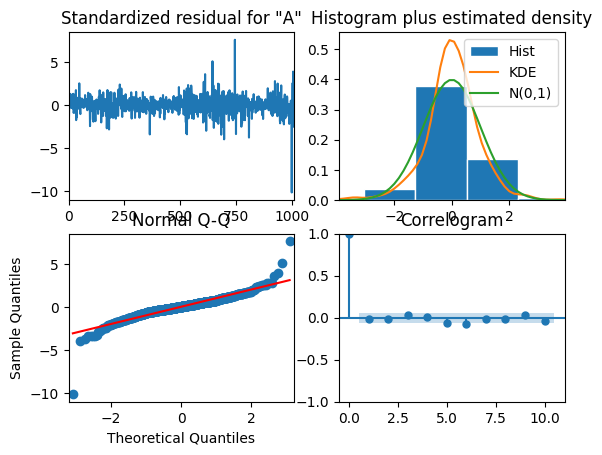

In [77]:
arima_model.plot_diagnostics()
plt.show()

In [78]:
mape = mean_absolute_percentage_error(df['Adj Close'], df['ARIMA'])
pa = predictive_accuracy(df['Adj Close'], df['ARIMA'])

# Convert PA from decimal to percentage
pa_percentage = pa * 100

# Print the results
print(f"MAPE: {mape:.2f}%")
print(f"Predictive Accuracy: {pa_percentage:.2f}%")

MAPE: 1.95%
Predictive Accuracy: 98.16%


In [79]:
forecast = arima_model.get_forecast(steps =12)
mean_forecast= forecast.predicted_mean
confidence_intervals= forecast.conf_int()
confidence_intervals
# Select lower and upper confidence limits
lower_limits = confidence_intervals.loc[:,'lower Adj Close']
upper_limits = confidence_intervals.loc[:,'upper Adj Close']

# Print best estimate predictions
print(mean_forecast.index.dtype)
print(mean_forecast)

int64
1009    410.075865
1010    410.158700
1011    410.085819
1012    410.149942
1013    410.093524
1014    410.143163
1015    410.099489
1016    410.137915
1017    410.104107
1018    410.133852
1019    410.107681
1020    410.130707
Name: predicted_mean, dtype: float64


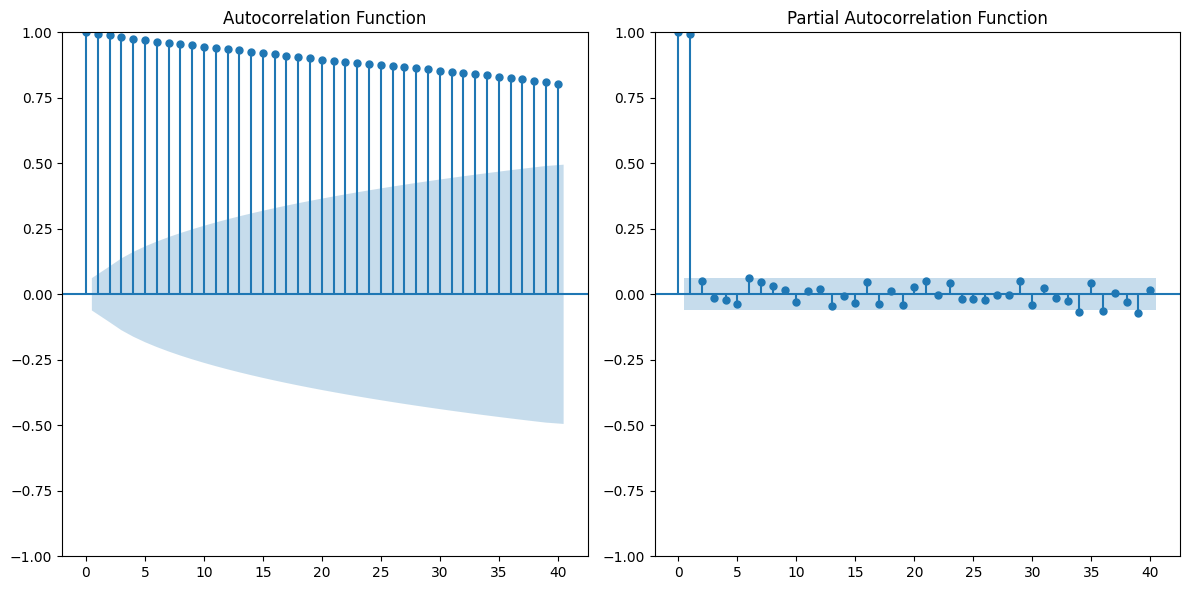

In [80]:
ts = df['Adj Close']
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)  # 1 row, 2 columns, 1st subplot
plot_acf(ts, ax=plt.gca(), lags=40)  # adjust the lags as necessary
plt.title('Autocorrelation Function')

plt.subplot(122)  # 1 row, 2 columns, 2nd subplot
plot_pacf(ts, ax=plt.gca(), lags=40, method='ywm')  # adjust the lags as necessary
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()

#### **Autocorrelation Function (ACF)**:

The ACF plot shows a gradual decline in autocorrelation as the lag increases. This suggests a strong autocorrelation at short lags that diminishes as the lags become larger, which is typical for time series data that have not been differenced.

#### **Partial Autocorrelation Function (PACF):**

The PACF plot shows a significant spike at lag 1, after which the partial autocorrelations fall within the confidence interval (the blue shaded area), which suggests that they are not significantly different from zero.

#Linear Regression

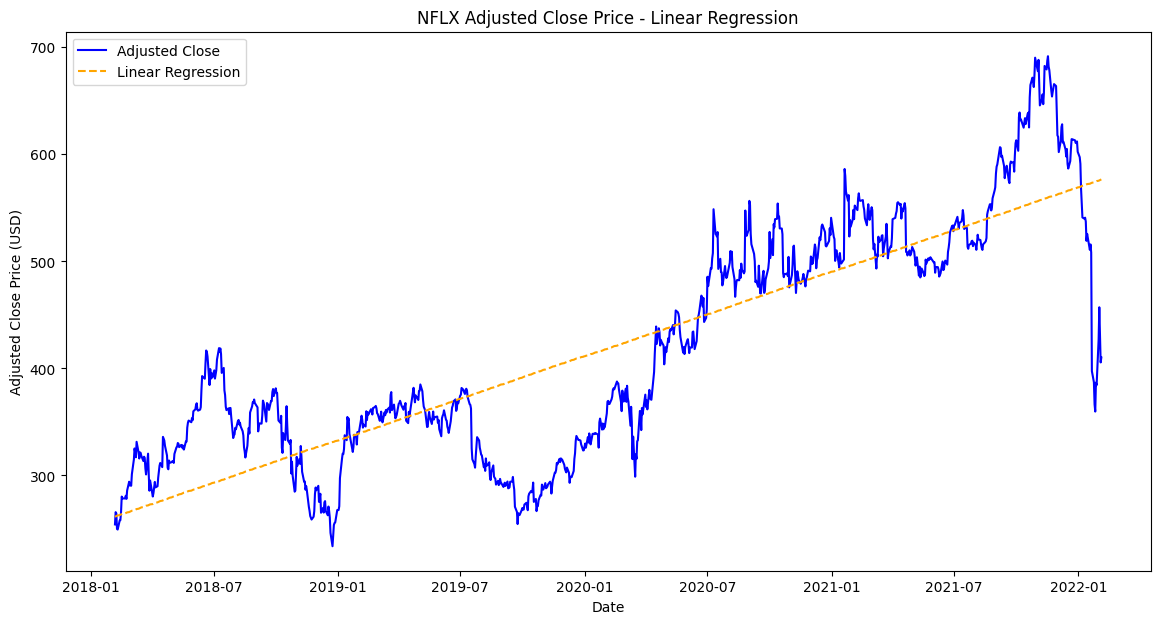

In [81]:
# Linear Regression
X = np.array(range(len(df))).reshape(-1, 1)
y = df['Adj Close'].values
lin_reg = LinearRegression().fit(X, y)
df['Linear Regression'] = lin_reg.predict(X)

plt.figure(figsize=(14, 7))
plt.plot(df['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(df['Linear Regression'], label='Linear Regression', color='orange', linestyle='--')
plt.title('NFLX Adjusted Close Price - Linear Regression')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (USD)')
plt.legend()
plt.show()

In [82]:
mape_lin_reg = mean_absolute_percentage_error(y, df['Linear Regression'])
pa_lin_reg = predictive_accuracy(y, df['Linear Regression'])
pa_percentage_lin_reg = pa_lin_reg * 100
print(f"MAPE for Linear Regression: {mape_lin_reg:.2f}%")
print(f"Predictive Accuracy for Linear Regression: {pa_percentage_lin_reg:.2f}%")

MAPE for Linear Regression: 12.07%
Predictive Accuracy for Linear Regression: 89.15%


#LSTM

In [83]:
import math
from statsmodels.tools.eval_measures import rmse
import keras
import tensorflow
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [84]:
df = df.iloc[:,1].values
df = df.reshape(-1,1)
df

array([[267.899994],
       [266.700012],
       [272.450012],
       ...,
       [451.980011],
       [429.26001 ],
       [412.769989]])

In [85]:
# Scaling the data
scalar =MinMaxScaler()
df=scalar.fit_transform(df)


In [86]:
# Split into train and test
train = df[:-200,:]
test = df[-200:,:]


In [87]:
print(len(train), len(test))

809 200


In [88]:
# Building the 2D array for supervised learning
def create_data(sequence, time_stemp):
    dataX = []
    dataY = []
    for i in range(len(sequence)-time_stemp-1):
        a = sequence[i:(i+time_stemp), 0]
        dataX.append(a)
        dataY.append(sequence[i + time_stemp, 0])
    return np.array(dataX),  np.array(dataY)

In [89]:
time_stemp = 1

In [90]:
# Apply the 2D array function to train and test datasets
train_X, train_Y = create_data(train,time_stemp)
test_X, test_Y =create_data(test, time_stemp)

In [91]:
# transform input from [samples, features] to [samples, timesteps, features] basically from 2D to 3D
train_X = np.reshape(train_X, (train_X.shape[0],1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

In [92]:
# Build the LSTM Model
model = Sequential()
# Adding the input layer and LSTM layer
model.add(LSTM(50, activation= 'relu', input_shape =(1, time_stemp)))
model.add(Dropout(0.15)) # Model does not overfit
model.add(Dense(1))
model.compile(optimizer ='adam', loss='mse')
model.fit(train_X, train_Y, batch_size=4, epochs =13, verbose=0)

In [93]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)
# inverting predictions
train_predict = scalar.inverse_transform(train_predict)
train_Y = scalar.inverse_transform([train_Y])
test_predict = scalar.inverse_transform(test_predict)
test_Y = scalar.inverse_transform([test_Y])
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(train_Y[0], train_predict[:,0]))
print('Train Score: %.3f RMSE' % (train_score))
test_score = math.sqrt(mean_squared_error(test_Y[0], test_predict[:,0]))
print('Test Score: %.3f RMSE' % (test_score))

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Train Score: 12.389 RMSE
Test Score: 16.666 RMSE


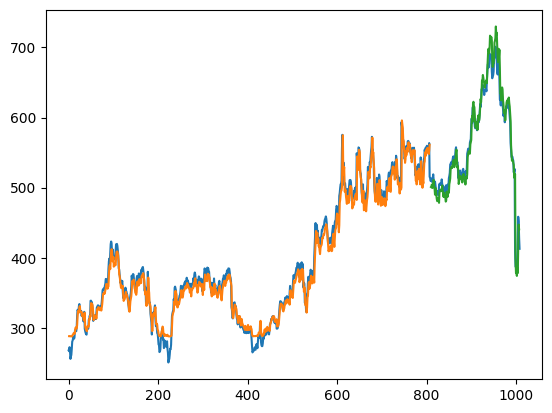

In [94]:
# shifting train
train_plot = np.empty_like(df) # create an array with the same shape as provided
train_plot[:, :] = np.nan
train_plot[time_stemp:len(train_predict)+time_stemp, :] = train_predict
# shifting test predictions for plotting
test_plot = np.empty_like(df)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_stemp*2)+1:len(df)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scalar.inverse_transform(df))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

In [95]:
#Calculate MAPE and PA for Training and Testing Data
train_mape = mean_absolute_percentage_error(train_Y[0], train_predict[:, 0])
test_mape = mean_absolute_percentage_error(test_Y[0], test_predict[:, 0])

train_pa = predictive_accuracy(train_Y[0], train_predict[:, 0])
test_pa = predictive_accuracy(test_Y[0], test_predict[:, 0])

# Convert PA from decimal to percentage
train_pa_percentage = train_pa * 100
test_pa_percentage = test_pa * 100

# Print the results
print(f"Training MAPE: {train_mape:.2f}%")
print(f"Testing MAPE: {test_mape:.2f}%")
print(f"Training Predictive Accuracy: {train_pa_percentage:.2f}%")
print(f"Testing Predictive Accuracy: {test_pa_percentage:.2f}%")

Training MAPE: 2.43%
Testing MAPE: 2.14%
Training Predictive Accuracy: 97.62%
Testing Predictive Accuracy: 97.88%


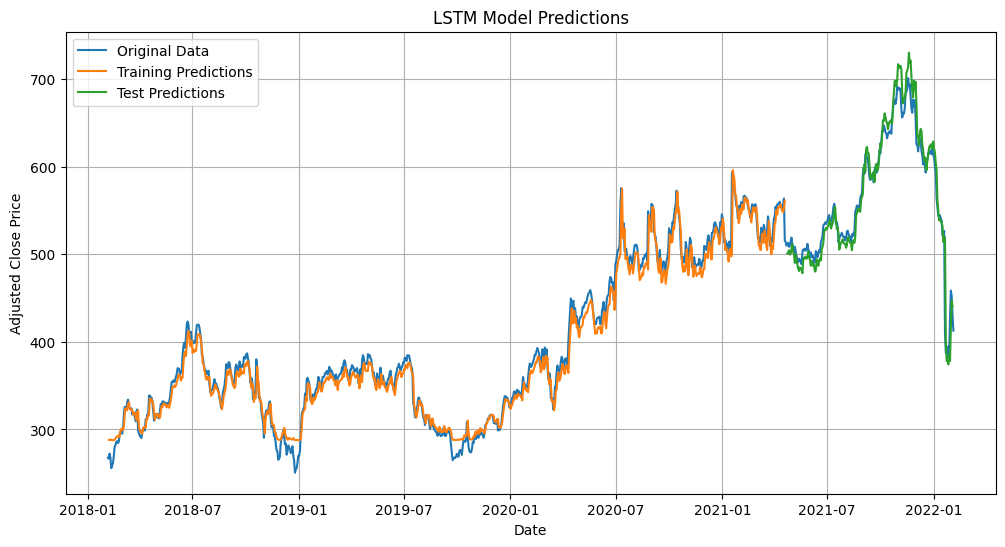

In [96]:
start_date = '2018-02-05'  
end_date = '2022-02-04'  
date_index = pd.date_range(start=start_date, end=end_date, periods=len(df))  

# Convert the NumPy array 'df' into a DataFrame with 'Date' column as index
df = pd.DataFrame(df, columns=['Adj Close'], index=date_index)

# Plotting with Date Values
plt.figure(figsize=(12, 6))
plt.plot(df.index, scalar.inverse_transform(df[['Adj Close']]), label='Original Data')
plt.plot(df.index[time_stemp:len(train_predict)+time_stemp], train_plot[time_stemp:len(train_predict)+time_stemp], label='Training Predictions')
plt.plot(df.index[len(train_predict)+(time_stemp*2)+1:len(df)-1], test_plot[len(train_predict)+(time_stemp*2)+1:len(df)-1], label='Test Predictions')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.title('LSTM Model Predictions')
plt.legend()
plt.grid(True)
plt.show()
